In [30]:
from __future__ import print_function, division

from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU, ReLU

import matplotlib.pyplot as plt
import sys
import numpy as np

In [46]:
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(ReLU())
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.1))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.1))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = fashion_mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)
               

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        #fig.savefig("images/%d.png" % epoch)
        plt.show()
        plt.close()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_17 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_176 (Dense)            (None, 256)               200960    
_________________________________________________________________
leaky_re_lu_126 (LeakyReLU)  (None, 256)               0         
_________________________________________________________________
dense_177 (Dense)            (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_127 (LeakyReLU)  (None, 512)               0         
_________________________________________________________________
dense_178 (Dense)            (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_128 (LeakyReLU)  (None, 512)               0         
__________

C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\keras\engine\training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.701811, acc.: 45.31%] [G loss: 0.614546]


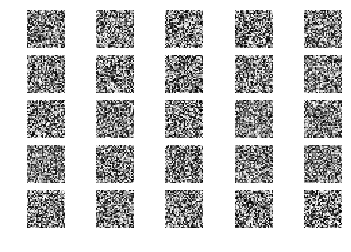

1 [D loss: 0.559624, acc.: 60.16%] [G loss: 0.658738]
2 [D loss: 0.401313, acc.: 84.38%] [G loss: 0.804752]
3 [D loss: 0.344299, acc.: 94.53%] [G loss: 1.000420]
4 [D loss: 0.258659, acc.: 99.22%] [G loss: 1.193748]
5 [D loss: 0.225789, acc.: 100.00%] [G loss: 1.446878]
6 [D loss: 0.171292, acc.: 100.00%] [G loss: 1.611130]
7 [D loss: 0.153954, acc.: 99.22%] [G loss: 1.805059]
8 [D loss: 0.111910, acc.: 100.00%] [G loss: 1.946514]
9 [D loss: 0.093462, acc.: 100.00%] [G loss: 2.178911]
10 [D loss: 0.086232, acc.: 100.00%] [G loss: 2.256371]
11 [D loss: 0.078848, acc.: 100.00%] [G loss: 2.480314]
12 [D loss: 0.060925, acc.: 100.00%] [G loss: 2.614327]
13 [D loss: 0.063150, acc.: 100.00%] [G loss: 2.752958]
14 [D loss: 0.053762, acc.: 100.00%] [G loss: 2.895581]
15 [D loss: 0.041599, acc.: 100.00%] [G loss: 2.962658]
16 [D loss: 0.034290, acc.: 100.00%] [G loss: 3.113644]
17 [D loss: 0.061450, acc.: 99.22%] [G loss: 3.142612]
18 [D loss: 0.037900, acc.: 100.00%] [G loss: 3.130601]
19 [D l

150 [D loss: 0.122655, acc.: 97.66%] [G loss: 3.215055]
151 [D loss: 0.220416, acc.: 90.62%] [G loss: 3.293907]
152 [D loss: 0.148766, acc.: 96.09%] [G loss: 3.058102]
153 [D loss: 0.251631, acc.: 89.06%] [G loss: 3.514583]
154 [D loss: 0.220852, acc.: 91.41%] [G loss: 3.353049]
155 [D loss: 0.188239, acc.: 96.88%] [G loss: 3.352467]
156 [D loss: 0.171993, acc.: 95.31%] [G loss: 3.241375]
157 [D loss: 0.251660, acc.: 88.28%] [G loss: 3.935224]
158 [D loss: 0.291356, acc.: 86.72%] [G loss: 3.710600]
159 [D loss: 0.169175, acc.: 94.53%] [G loss: 3.693076]
160 [D loss: 0.174694, acc.: 92.97%] [G loss: 3.607271]
161 [D loss: 0.243815, acc.: 89.84%] [G loss: 3.923589]
162 [D loss: 0.248461, acc.: 90.62%] [G loss: 3.537687]
163 [D loss: 0.154641, acc.: 96.88%] [G loss: 3.860437]
164 [D loss: 0.185335, acc.: 92.19%] [G loss: 3.415695]
165 [D loss: 0.139294, acc.: 95.31%] [G loss: 3.937587]
166 [D loss: 0.189157, acc.: 92.97%] [G loss: 3.701755]
167 [D loss: 0.244627, acc.: 88.28%] [G loss: 3.

298 [D loss: 0.321211, acc.: 84.38%] [G loss: 3.067082]
299 [D loss: 0.383287, acc.: 78.12%] [G loss: 3.588193]
300 [D loss: 0.802236, acc.: 61.72%] [G loss: 2.665673]
301 [D loss: 0.296536, acc.: 82.03%] [G loss: 3.571403]
302 [D loss: 0.313575, acc.: 87.50%] [G loss: 3.115776]
303 [D loss: 0.303820, acc.: 83.59%] [G loss: 3.316729]
304 [D loss: 0.244462, acc.: 89.06%] [G loss: 3.454234]
305 [D loss: 0.309796, acc.: 87.50%] [G loss: 2.939594]
306 [D loss: 0.379467, acc.: 85.16%] [G loss: 2.973155]
307 [D loss: 0.293019, acc.: 87.50%] [G loss: 2.975378]
308 [D loss: 0.249749, acc.: 92.19%] [G loss: 3.598752]
309 [D loss: 0.457813, acc.: 78.91%] [G loss: 3.092457]
310 [D loss: 0.247341, acc.: 89.06%] [G loss: 4.195152]
311 [D loss: 0.753786, acc.: 64.84%] [G loss: 3.143671]
312 [D loss: 0.227262, acc.: 90.62%] [G loss: 3.612230]
313 [D loss: 0.590982, acc.: 72.66%] [G loss: 2.940148]
314 [D loss: 0.325540, acc.: 82.81%] [G loss: 3.674150]
315 [D loss: 0.264721, acc.: 91.41%] [G loss: 2.

445 [D loss: 0.518522, acc.: 71.88%] [G loss: 2.451995]
446 [D loss: 0.263482, acc.: 92.97%] [G loss: 2.797944]
447 [D loss: 0.315982, acc.: 82.81%] [G loss: 2.754861]
448 [D loss: 0.341682, acc.: 89.06%] [G loss: 3.299601]
449 [D loss: 0.471483, acc.: 77.34%] [G loss: 2.712971]
450 [D loss: 0.300686, acc.: 88.28%] [G loss: 3.186899]
451 [D loss: 0.330463, acc.: 85.16%] [G loss: 2.574979]
452 [D loss: 0.343992, acc.: 84.38%] [G loss: 3.334955]
453 [D loss: 0.278203, acc.: 95.31%] [G loss: 3.591362]
454 [D loss: 0.341626, acc.: 85.16%] [G loss: 2.777541]
455 [D loss: 0.281010, acc.: 88.28%] [G loss: 3.411592]
456 [D loss: 0.255685, acc.: 95.31%] [G loss: 3.067214]
457 [D loss: 0.508231, acc.: 71.88%] [G loss: 3.159457]
458 [D loss: 0.303993, acc.: 90.62%] [G loss: 2.749894]
459 [D loss: 0.264794, acc.: 92.97%] [G loss: 3.324617]
460 [D loss: 0.354193, acc.: 82.03%] [G loss: 3.068021]
461 [D loss: 0.293783, acc.: 88.28%] [G loss: 3.382487]
462 [D loss: 0.365631, acc.: 82.03%] [G loss: 3.

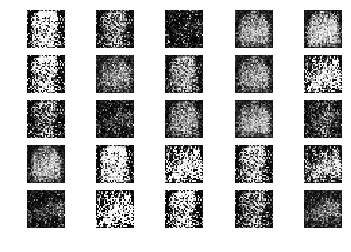

501 [D loss: 0.330808, acc.: 89.06%] [G loss: 3.196975]
502 [D loss: 0.557505, acc.: 71.88%] [G loss: 3.697178]
503 [D loss: 0.482262, acc.: 78.12%] [G loss: 3.167412]
504 [D loss: 0.422677, acc.: 88.28%] [G loss: 3.021844]
505 [D loss: 0.319510, acc.: 87.50%] [G loss: 3.767210]
506 [D loss: 0.409986, acc.: 83.59%] [G loss: 2.968595]
507 [D loss: 0.313405, acc.: 90.62%] [G loss: 3.416667]
508 [D loss: 0.420428, acc.: 82.03%] [G loss: 3.227947]
509 [D loss: 0.438399, acc.: 81.25%] [G loss: 3.860944]
510 [D loss: 0.323109, acc.: 86.72%] [G loss: 3.366571]
511 [D loss: 0.325741, acc.: 89.84%] [G loss: 3.150624]
512 [D loss: 0.383297, acc.: 82.81%] [G loss: 3.602208]
513 [D loss: 0.376980, acc.: 87.50%] [G loss: 2.902560]
514 [D loss: 0.479256, acc.: 78.12%] [G loss: 4.519815]
515 [D loss: 0.771919, acc.: 59.38%] [G loss: 2.678098]
516 [D loss: 0.259463, acc.: 90.62%] [G loss: 3.708806]
517 [D loss: 0.398805, acc.: 77.34%] [G loss: 3.411631]
518 [D loss: 0.237739, acc.: 93.75%] [G loss: 3.

648 [D loss: 0.313532, acc.: 94.53%] [G loss: 2.461306]
649 [D loss: 0.524257, acc.: 77.34%] [G loss: 2.360223]
650 [D loss: 0.491812, acc.: 75.78%] [G loss: 2.453817]
651 [D loss: 0.375432, acc.: 89.06%] [G loss: 2.535806]
652 [D loss: 0.675925, acc.: 59.38%] [G loss: 2.180677]
653 [D loss: 0.320285, acc.: 91.41%] [G loss: 2.900413]
654 [D loss: 0.665838, acc.: 67.97%] [G loss: 2.267741]
655 [D loss: 0.408475, acc.: 86.72%] [G loss: 2.412602]
656 [D loss: 0.484025, acc.: 81.25%] [G loss: 2.713091]
657 [D loss: 0.437963, acc.: 84.38%] [G loss: 2.655323]
658 [D loss: 0.521677, acc.: 77.34%] [G loss: 2.370976]
659 [D loss: 0.572286, acc.: 72.66%] [G loss: 2.511774]
660 [D loss: 0.604706, acc.: 64.84%] [G loss: 2.482594]
661 [D loss: 0.584476, acc.: 77.34%] [G loss: 2.231787]
662 [D loss: 0.580098, acc.: 71.88%] [G loss: 2.532982]
663 [D loss: 0.497451, acc.: 71.88%] [G loss: 2.293444]
664 [D loss: 0.517212, acc.: 76.56%] [G loss: 2.520580]
665 [D loss: 0.437095, acc.: 83.59%] [G loss: 2.

796 [D loss: 0.463373, acc.: 78.91%] [G loss: 1.924769]
797 [D loss: 0.545578, acc.: 75.78%] [G loss: 1.755591]
798 [D loss: 0.548354, acc.: 72.66%] [G loss: 1.661525]
799 [D loss: 0.508019, acc.: 78.12%] [G loss: 1.912038]
800 [D loss: 0.485047, acc.: 75.00%] [G loss: 2.077731]
801 [D loss: 0.499280, acc.: 80.47%] [G loss: 1.852465]
802 [D loss: 0.481618, acc.: 79.69%] [G loss: 1.958057]
803 [D loss: 0.582230, acc.: 74.22%] [G loss: 2.164274]
804 [D loss: 0.585698, acc.: 72.66%] [G loss: 1.707742]
805 [D loss: 0.478186, acc.: 82.03%] [G loss: 1.723543]
806 [D loss: 0.536371, acc.: 74.22%] [G loss: 2.216650]
807 [D loss: 0.683847, acc.: 60.94%] [G loss: 1.545720]
808 [D loss: 0.471217, acc.: 81.25%] [G loss: 1.551014]
809 [D loss: 0.453737, acc.: 80.47%] [G loss: 2.054011]
810 [D loss: 0.491934, acc.: 75.00%] [G loss: 1.833124]
811 [D loss: 0.499171, acc.: 73.44%] [G loss: 2.003272]
812 [D loss: 0.538462, acc.: 75.78%] [G loss: 1.849799]
813 [D loss: 0.552805, acc.: 77.34%] [G loss: 1.

942 [D loss: 0.401963, acc.: 81.25%] [G loss: 1.765397]
943 [D loss: 0.434683, acc.: 81.25%] [G loss: 1.744153]
944 [D loss: 0.529513, acc.: 75.78%] [G loss: 1.564159]
945 [D loss: 0.483125, acc.: 76.56%] [G loss: 1.717282]
946 [D loss: 0.485490, acc.: 77.34%] [G loss: 1.696765]
947 [D loss: 0.536547, acc.: 69.53%] [G loss: 1.695124]
948 [D loss: 0.537430, acc.: 76.56%] [G loss: 1.836897]
949 [D loss: 0.572225, acc.: 76.56%] [G loss: 1.469702]
950 [D loss: 0.624742, acc.: 54.69%] [G loss: 1.462463]
951 [D loss: 0.528495, acc.: 73.44%] [G loss: 1.613485]
952 [D loss: 0.499146, acc.: 80.47%] [G loss: 1.310367]
953 [D loss: 0.486322, acc.: 74.22%] [G loss: 1.478418]
954 [D loss: 0.402784, acc.: 86.72%] [G loss: 1.831880]
955 [D loss: 0.518326, acc.: 75.78%] [G loss: 1.808730]
956 [D loss: 0.425776, acc.: 82.03%] [G loss: 1.749429]
957 [D loss: 0.621281, acc.: 65.62%] [G loss: 1.602765]
958 [D loss: 0.471711, acc.: 81.25%] [G loss: 1.700955]
959 [D loss: 0.501645, acc.: 75.78%] [G loss: 1.

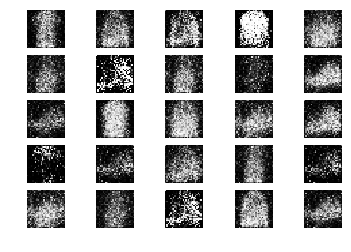

1001 [D loss: 0.540432, acc.: 72.66%] [G loss: 1.643856]
1002 [D loss: 0.434670, acc.: 83.59%] [G loss: 1.789335]
1003 [D loss: 0.469389, acc.: 75.00%] [G loss: 1.607754]
1004 [D loss: 0.481850, acc.: 77.34%] [G loss: 1.604117]
1005 [D loss: 0.445624, acc.: 84.38%] [G loss: 1.706108]
1006 [D loss: 0.446199, acc.: 82.81%] [G loss: 1.930483]
1007 [D loss: 0.616490, acc.: 67.97%] [G loss: 1.447954]
1008 [D loss: 0.448628, acc.: 80.47%] [G loss: 1.762245]
1009 [D loss: 0.433689, acc.: 80.47%] [G loss: 1.599218]
1010 [D loss: 0.539511, acc.: 75.00%] [G loss: 1.559597]
1011 [D loss: 0.528894, acc.: 74.22%] [G loss: 1.509603]
1012 [D loss: 0.582260, acc.: 73.44%] [G loss: 1.480827]
1013 [D loss: 0.552906, acc.: 71.88%] [G loss: 1.774123]
1014 [D loss: 0.534767, acc.: 75.00%] [G loss: 1.514076]
1015 [D loss: 0.489236, acc.: 79.69%] [G loss: 1.517932]
1016 [D loss: 0.593214, acc.: 69.53%] [G loss: 1.741201]
1017 [D loss: 0.543219, acc.: 70.31%] [G loss: 1.555891]
1018 [D loss: 0.544058, acc.: 7

1146 [D loss: 0.490843, acc.: 78.91%] [G loss: 1.517997]
1147 [D loss: 0.625904, acc.: 66.41%] [G loss: 1.379183]
1148 [D loss: 0.600023, acc.: 66.41%] [G loss: 1.543375]
1149 [D loss: 0.661321, acc.: 64.06%] [G loss: 1.343887]
1150 [D loss: 0.444076, acc.: 83.59%] [G loss: 1.540230]
1151 [D loss: 0.532734, acc.: 76.56%] [G loss: 1.608513]
1152 [D loss: 0.493433, acc.: 74.22%] [G loss: 1.523463]
1153 [D loss: 0.538443, acc.: 73.44%] [G loss: 1.498143]
1154 [D loss: 0.439029, acc.: 82.03%] [G loss: 1.531497]
1155 [D loss: 0.487164, acc.: 76.56%] [G loss: 1.563246]
1156 [D loss: 0.509309, acc.: 75.78%] [G loss: 1.423819]
1157 [D loss: 0.570484, acc.: 64.84%] [G loss: 1.559287]
1158 [D loss: 0.540414, acc.: 69.53%] [G loss: 1.513645]
1159 [D loss: 0.645724, acc.: 61.72%] [G loss: 1.554387]
1160 [D loss: 0.521641, acc.: 71.09%] [G loss: 1.496614]
1161 [D loss: 0.552250, acc.: 65.62%] [G loss: 1.546654]
1162 [D loss: 0.471247, acc.: 78.12%] [G loss: 1.539249]
1163 [D loss: 0.592297, acc.: 6

1290 [D loss: 0.608152, acc.: 71.09%] [G loss: 1.073803]
1291 [D loss: 0.674850, acc.: 60.16%] [G loss: 1.370015]
1292 [D loss: 0.566387, acc.: 72.66%] [G loss: 1.403876]
1293 [D loss: 0.576558, acc.: 75.00%] [G loss: 1.352333]
1294 [D loss: 0.648476, acc.: 67.97%] [G loss: 1.369178]
1295 [D loss: 0.622899, acc.: 64.84%] [G loss: 1.400849]
1296 [D loss: 0.562638, acc.: 67.19%] [G loss: 1.363955]
1297 [D loss: 0.580210, acc.: 67.19%] [G loss: 1.362075]
1298 [D loss: 0.580179, acc.: 70.31%] [G loss: 1.007590]
1299 [D loss: 0.591994, acc.: 71.09%] [G loss: 1.228710]
1300 [D loss: 0.690854, acc.: 57.81%] [G loss: 1.479561]
1301 [D loss: 0.615037, acc.: 67.19%] [G loss: 1.454773]
1302 [D loss: 0.559891, acc.: 72.66%] [G loss: 1.336943]
1303 [D loss: 0.530239, acc.: 74.22%] [G loss: 1.359792]
1304 [D loss: 0.589023, acc.: 65.62%] [G loss: 1.354268]
1305 [D loss: 0.631566, acc.: 65.62%] [G loss: 1.178662]
1306 [D loss: 0.620352, acc.: 57.81%] [G loss: 1.208196]
1307 [D loss: 0.609778, acc.: 6

1434 [D loss: 0.567260, acc.: 73.44%] [G loss: 1.263500]
1435 [D loss: 0.640075, acc.: 64.06%] [G loss: 1.274049]
1436 [D loss: 0.550511, acc.: 78.12%] [G loss: 1.285918]
1437 [D loss: 0.630493, acc.: 66.41%] [G loss: 1.214731]
1438 [D loss: 0.604616, acc.: 62.50%] [G loss: 1.202029]
1439 [D loss: 0.573744, acc.: 68.75%] [G loss: 1.201478]
1440 [D loss: 0.634634, acc.: 61.72%] [G loss: 1.196362]
1441 [D loss: 0.639947, acc.: 63.28%] [G loss: 1.170207]
1442 [D loss: 0.630550, acc.: 64.84%] [G loss: 1.186696]
1443 [D loss: 0.635075, acc.: 60.16%] [G loss: 1.159293]
1444 [D loss: 0.591181, acc.: 58.59%] [G loss: 1.126234]
1445 [D loss: 0.540667, acc.: 72.66%] [G loss: 1.206864]
1446 [D loss: 0.644262, acc.: 62.50%] [G loss: 1.136259]
1447 [D loss: 0.638913, acc.: 62.50%] [G loss: 1.068295]
1448 [D loss: 0.576261, acc.: 66.41%] [G loss: 1.142498]
1449 [D loss: 0.507883, acc.: 75.00%] [G loss: 1.172233]
1450 [D loss: 0.577233, acc.: 71.88%] [G loss: 1.208239]
1451 [D loss: 0.587300, acc.: 6

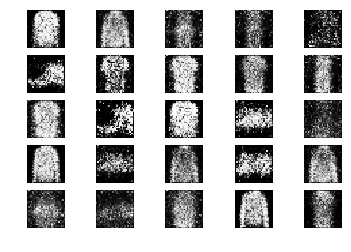

1501 [D loss: 0.637275, acc.: 65.62%] [G loss: 1.077602]
1502 [D loss: 0.573395, acc.: 67.97%] [G loss: 1.073611]
1503 [D loss: 0.651354, acc.: 68.75%] [G loss: 1.109300]
1504 [D loss: 0.585934, acc.: 71.88%] [G loss: 1.228378]
1505 [D loss: 0.543118, acc.: 71.09%] [G loss: 1.112830]
1506 [D loss: 0.643365, acc.: 66.41%] [G loss: 1.165573]
1507 [D loss: 0.517650, acc.: 75.00%] [G loss: 1.159877]
1508 [D loss: 0.598458, acc.: 64.84%] [G loss: 1.217206]
1509 [D loss: 0.605089, acc.: 68.75%] [G loss: 1.172499]
1510 [D loss: 0.600725, acc.: 65.62%] [G loss: 1.145929]
1511 [D loss: 0.576642, acc.: 68.75%] [G loss: 1.183403]
1512 [D loss: 0.647650, acc.: 57.03%] [G loss: 1.148587]
1513 [D loss: 0.588610, acc.: 66.41%] [G loss: 1.167288]
1514 [D loss: 0.595616, acc.: 68.75%] [G loss: 1.181191]
1515 [D loss: 0.500245, acc.: 77.34%] [G loss: 1.276838]
1516 [D loss: 0.599936, acc.: 75.00%] [G loss: 1.289395]
1517 [D loss: 0.623544, acc.: 58.59%] [G loss: 1.371037]
1518 [D loss: 0.680879, acc.: 6

1647 [D loss: 0.571703, acc.: 64.84%] [G loss: 1.229712]
1648 [D loss: 0.603645, acc.: 66.41%] [G loss: 1.215884]
1649 [D loss: 0.548562, acc.: 75.00%] [G loss: 1.085333]
1650 [D loss: 0.601611, acc.: 67.97%] [G loss: 1.106460]
1651 [D loss: 0.574710, acc.: 72.66%] [G loss: 1.066998]
1652 [D loss: 0.547190, acc.: 68.75%] [G loss: 1.116898]
1653 [D loss: 0.592728, acc.: 67.19%] [G loss: 1.192261]
1654 [D loss: 0.619702, acc.: 63.28%] [G loss: 1.112381]
1655 [D loss: 0.587932, acc.: 69.53%] [G loss: 1.043580]
1656 [D loss: 0.606892, acc.: 66.41%] [G loss: 1.117340]
1657 [D loss: 0.583057, acc.: 65.62%] [G loss: 1.221575]
1658 [D loss: 0.556584, acc.: 68.75%] [G loss: 1.167469]
1659 [D loss: 0.540344, acc.: 72.66%] [G loss: 1.175493]
1660 [D loss: 0.573188, acc.: 67.19%] [G loss: 1.189140]
1661 [D loss: 0.520576, acc.: 77.34%] [G loss: 1.191064]
1662 [D loss: 0.528394, acc.: 75.78%] [G loss: 1.064008]
1663 [D loss: 0.509487, acc.: 77.34%] [G loss: 1.164679]
1664 [D loss: 0.565699, acc.: 6

1791 [D loss: 0.588586, acc.: 62.50%] [G loss: 1.129576]
1792 [D loss: 0.539850, acc.: 77.34%] [G loss: 1.160213]
1793 [D loss: 0.572981, acc.: 67.97%] [G loss: 1.181307]
1794 [D loss: 0.590241, acc.: 66.41%] [G loss: 1.176074]
1795 [D loss: 0.490973, acc.: 75.78%] [G loss: 1.165252]
1796 [D loss: 0.589276, acc.: 64.84%] [G loss: 1.316210]
1797 [D loss: 0.608692, acc.: 62.50%] [G loss: 1.168243]
1798 [D loss: 0.618887, acc.: 64.06%] [G loss: 1.069121]
1799 [D loss: 0.561311, acc.: 69.53%] [G loss: 0.965014]
1800 [D loss: 0.571864, acc.: 66.41%] [G loss: 1.089183]
1801 [D loss: 0.599017, acc.: 66.41%] [G loss: 1.048576]
1802 [D loss: 0.630063, acc.: 60.94%] [G loss: 1.212771]
1803 [D loss: 0.572555, acc.: 69.53%] [G loss: 1.117867]
1804 [D loss: 0.615303, acc.: 62.50%] [G loss: 1.171318]
1805 [D loss: 0.578127, acc.: 69.53%] [G loss: 1.067529]
1806 [D loss: 0.590574, acc.: 65.62%] [G loss: 1.192170]
1807 [D loss: 0.592032, acc.: 66.41%] [G loss: 1.147449]
1808 [D loss: 0.540759, acc.: 7

1935 [D loss: 0.566747, acc.: 67.97%] [G loss: 1.055286]
1936 [D loss: 0.629305, acc.: 60.16%] [G loss: 1.032367]
1937 [D loss: 0.624077, acc.: 63.28%] [G loss: 1.001450]
1938 [D loss: 0.649790, acc.: 58.59%] [G loss: 1.053323]
1939 [D loss: 0.581402, acc.: 64.06%] [G loss: 1.137829]
1940 [D loss: 0.614168, acc.: 63.28%] [G loss: 1.143413]
1941 [D loss: 0.559856, acc.: 70.31%] [G loss: 1.166347]
1942 [D loss: 0.553649, acc.: 67.97%] [G loss: 1.172371]
1943 [D loss: 0.535761, acc.: 71.09%] [G loss: 1.294624]
1944 [D loss: 0.595887, acc.: 64.06%] [G loss: 1.230952]
1945 [D loss: 0.585038, acc.: 65.62%] [G loss: 1.187093]
1946 [D loss: 0.556277, acc.: 67.97%] [G loss: 1.275830]
1947 [D loss: 0.580123, acc.: 67.97%] [G loss: 1.101882]
1948 [D loss: 0.573517, acc.: 67.97%] [G loss: 1.135594]
1949 [D loss: 0.586514, acc.: 66.41%] [G loss: 1.209480]
1950 [D loss: 0.658167, acc.: 61.72%] [G loss: 1.149814]
1951 [D loss: 0.507420, acc.: 75.00%] [G loss: 1.086792]
1952 [D loss: 0.527979, acc.: 7

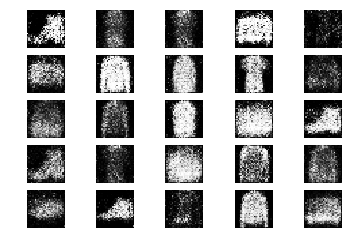

2001 [D loss: 0.606288, acc.: 64.84%] [G loss: 1.101626]
2002 [D loss: 0.606251, acc.: 64.84%] [G loss: 1.061656]
2003 [D loss: 0.620510, acc.: 62.50%] [G loss: 1.173008]
2004 [D loss: 0.616329, acc.: 64.84%] [G loss: 1.170342]
2005 [D loss: 0.577382, acc.: 71.88%] [G loss: 1.244147]
2006 [D loss: 0.566710, acc.: 73.44%] [G loss: 1.160048]
2007 [D loss: 0.575401, acc.: 69.53%] [G loss: 1.164474]
2008 [D loss: 0.594908, acc.: 67.97%] [G loss: 1.140251]
2009 [D loss: 0.499476, acc.: 76.56%] [G loss: 1.160178]
2010 [D loss: 0.596520, acc.: 64.06%] [G loss: 1.141806]
2011 [D loss: 0.535197, acc.: 71.09%] [G loss: 1.168857]
2012 [D loss: 0.581865, acc.: 65.62%] [G loss: 1.237687]
2013 [D loss: 0.519206, acc.: 74.22%] [G loss: 1.082235]
2014 [D loss: 0.583354, acc.: 67.97%] [G loss: 1.165375]
2015 [D loss: 0.532982, acc.: 73.44%] [G loss: 1.240456]
2016 [D loss: 0.577312, acc.: 72.66%] [G loss: 1.096627]
2017 [D loss: 0.625669, acc.: 62.50%] [G loss: 1.108374]
2018 [D loss: 0.565288, acc.: 6

2146 [D loss: 0.519213, acc.: 73.44%] [G loss: 1.123329]
2147 [D loss: 0.620894, acc.: 64.06%] [G loss: 1.107035]
2148 [D loss: 0.638421, acc.: 64.84%] [G loss: 1.138958]
2149 [D loss: 0.618943, acc.: 60.94%] [G loss: 1.127162]
2150 [D loss: 0.573799, acc.: 66.41%] [G loss: 1.116820]
2151 [D loss: 0.580777, acc.: 72.66%] [G loss: 1.137877]
2152 [D loss: 0.643372, acc.: 64.84%] [G loss: 1.135994]
2153 [D loss: 0.626244, acc.: 63.28%] [G loss: 1.156689]
2154 [D loss: 0.605631, acc.: 65.62%] [G loss: 1.018350]
2155 [D loss: 0.584592, acc.: 64.84%] [G loss: 1.075261]
2156 [D loss: 0.602738, acc.: 71.09%] [G loss: 1.168840]
2157 [D loss: 0.635884, acc.: 65.62%] [G loss: 1.153229]
2158 [D loss: 0.674361, acc.: 62.50%] [G loss: 1.107885]
2159 [D loss: 0.603103, acc.: 69.53%] [G loss: 1.111265]
2160 [D loss: 0.597609, acc.: 64.84%] [G loss: 1.098640]
2161 [D loss: 0.522234, acc.: 71.88%] [G loss: 1.156194]
2162 [D loss: 0.622632, acc.: 63.28%] [G loss: 1.150199]
2163 [D loss: 0.563272, acc.: 7

2290 [D loss: 0.612212, acc.: 64.06%] [G loss: 1.102345]
2291 [D loss: 0.590734, acc.: 70.31%] [G loss: 1.118162]
2292 [D loss: 0.651707, acc.: 57.81%] [G loss: 1.079377]
2293 [D loss: 0.570124, acc.: 69.53%] [G loss: 1.099815]
2294 [D loss: 0.566230, acc.: 70.31%] [G loss: 1.099898]
2295 [D loss: 0.648882, acc.: 61.72%] [G loss: 1.122271]
2296 [D loss: 0.604888, acc.: 62.50%] [G loss: 1.024650]
2297 [D loss: 0.586559, acc.: 69.53%] [G loss: 1.018207]
2298 [D loss: 0.548672, acc.: 73.44%] [G loss: 1.065900]
2299 [D loss: 0.586815, acc.: 71.88%] [G loss: 1.268213]
2300 [D loss: 0.610154, acc.: 70.31%] [G loss: 1.102711]
2301 [D loss: 0.602028, acc.: 63.28%] [G loss: 0.996458]
2302 [D loss: 0.632144, acc.: 56.25%] [G loss: 1.013538]
2303 [D loss: 0.517808, acc.: 76.56%] [G loss: 1.063674]
2304 [D loss: 0.614035, acc.: 62.50%] [G loss: 1.101428]
2305 [D loss: 0.511695, acc.: 74.22%] [G loss: 1.285008]
2306 [D loss: 0.602078, acc.: 65.62%] [G loss: 1.179408]
2307 [D loss: 0.612575, acc.: 6

2434 [D loss: 0.516389, acc.: 75.78%] [G loss: 1.111020]
2435 [D loss: 0.575470, acc.: 67.97%] [G loss: 1.177703]
2436 [D loss: 0.634100, acc.: 65.62%] [G loss: 1.124177]
2437 [D loss: 0.535866, acc.: 68.75%] [G loss: 1.218165]
2438 [D loss: 0.583137, acc.: 64.84%] [G loss: 1.100610]
2439 [D loss: 0.578548, acc.: 69.53%] [G loss: 1.146674]
2440 [D loss: 0.592206, acc.: 66.41%] [G loss: 1.103665]
2441 [D loss: 0.666053, acc.: 61.72%] [G loss: 1.110131]
2442 [D loss: 0.605439, acc.: 69.53%] [G loss: 1.075647]
2443 [D loss: 0.630783, acc.: 64.84%] [G loss: 1.020344]
2444 [D loss: 0.625926, acc.: 63.28%] [G loss: 0.955745]
2445 [D loss: 0.538349, acc.: 67.19%] [G loss: 1.099049]
2446 [D loss: 0.619024, acc.: 67.19%] [G loss: 1.047453]
2447 [D loss: 0.572323, acc.: 67.97%] [G loss: 1.141746]
2448 [D loss: 0.594539, acc.: 67.97%] [G loss: 1.096460]
2449 [D loss: 0.546319, acc.: 73.44%] [G loss: 1.239080]
2450 [D loss: 0.599468, acc.: 70.31%] [G loss: 1.068414]
2451 [D loss: 0.628360, acc.: 6

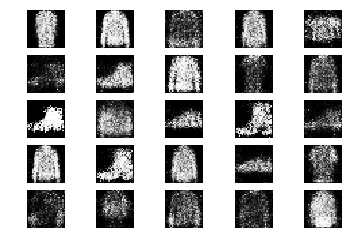

2501 [D loss: 0.546863, acc.: 72.66%] [G loss: 1.054865]
2502 [D loss: 0.514053, acc.: 70.31%] [G loss: 1.175731]
2503 [D loss: 0.552909, acc.: 73.44%] [G loss: 1.205706]
2504 [D loss: 0.622745, acc.: 64.06%] [G loss: 1.178088]
2505 [D loss: 0.621218, acc.: 66.41%] [G loss: 1.203505]
2506 [D loss: 0.649467, acc.: 64.06%] [G loss: 1.163701]
2507 [D loss: 0.561046, acc.: 74.22%] [G loss: 1.112409]
2508 [D loss: 0.551098, acc.: 71.09%] [G loss: 1.119223]
2509 [D loss: 0.572851, acc.: 68.75%] [G loss: 1.081769]
2510 [D loss: 0.610998, acc.: 71.09%] [G loss: 1.041257]
2511 [D loss: 0.632533, acc.: 63.28%] [G loss: 1.124702]
2512 [D loss: 0.542836, acc.: 72.66%] [G loss: 1.136223]
2513 [D loss: 0.609688, acc.: 65.62%] [G loss: 1.070165]
2514 [D loss: 0.669863, acc.: 60.16%] [G loss: 1.048734]
2515 [D loss: 0.586175, acc.: 68.75%] [G loss: 1.021484]
2516 [D loss: 0.568725, acc.: 68.75%] [G loss: 1.188848]
2517 [D loss: 0.655272, acc.: 58.59%] [G loss: 1.083048]
2518 [D loss: 0.620133, acc.: 6

2647 [D loss: 0.582824, acc.: 69.53%] [G loss: 1.249376]
2648 [D loss: 0.650925, acc.: 58.59%] [G loss: 1.118406]
2649 [D loss: 0.599791, acc.: 65.62%] [G loss: 1.017289]
2650 [D loss: 0.581004, acc.: 67.19%] [G loss: 1.053379]
2651 [D loss: 0.579803, acc.: 67.97%] [G loss: 1.111877]
2652 [D loss: 0.570284, acc.: 68.75%] [G loss: 1.086935]
2653 [D loss: 0.610498, acc.: 65.62%] [G loss: 1.123075]
2654 [D loss: 0.611910, acc.: 64.84%] [G loss: 1.192967]
2655 [D loss: 0.626303, acc.: 61.72%] [G loss: 1.066723]
2656 [D loss: 0.514955, acc.: 67.97%] [G loss: 1.200061]
2657 [D loss: 0.593215, acc.: 67.19%] [G loss: 1.132556]
2658 [D loss: 0.570728, acc.: 64.84%] [G loss: 1.269412]
2659 [D loss: 0.590854, acc.: 64.84%] [G loss: 1.170618]
2660 [D loss: 0.618305, acc.: 61.72%] [G loss: 1.085281]
2661 [D loss: 0.573572, acc.: 71.88%] [G loss: 1.039392]
2662 [D loss: 0.603043, acc.: 65.62%] [G loss: 1.065128]
2663 [D loss: 0.644410, acc.: 58.59%] [G loss: 1.062169]
2664 [D loss: 0.574399, acc.: 6

2793 [D loss: 0.534059, acc.: 74.22%] [G loss: 1.011489]
2794 [D loss: 0.548357, acc.: 75.00%] [G loss: 1.168884]
2795 [D loss: 0.581758, acc.: 67.97%] [G loss: 1.094179]
2796 [D loss: 0.571866, acc.: 71.88%] [G loss: 1.155890]
2797 [D loss: 0.472559, acc.: 78.91%] [G loss: 1.177696]
2798 [D loss: 0.656280, acc.: 61.72%] [G loss: 1.183776]
2799 [D loss: 0.528058, acc.: 76.56%] [G loss: 1.144371]
2800 [D loss: 0.581709, acc.: 67.97%] [G loss: 1.149832]
2801 [D loss: 0.550365, acc.: 68.75%] [G loss: 1.178178]
2802 [D loss: 0.529159, acc.: 72.66%] [G loss: 1.203881]
2803 [D loss: 0.574474, acc.: 69.53%] [G loss: 1.234289]
2804 [D loss: 0.531754, acc.: 73.44%] [G loss: 1.169856]
2805 [D loss: 0.622084, acc.: 62.50%] [G loss: 1.012573]
2806 [D loss: 0.649187, acc.: 61.72%] [G loss: 1.055423]
2807 [D loss: 0.548343, acc.: 68.75%] [G loss: 1.214939]
2808 [D loss: 0.628142, acc.: 64.84%] [G loss: 1.195023]
2809 [D loss: 0.632273, acc.: 63.28%] [G loss: 1.092546]
2810 [D loss: 0.614091, acc.: 6

2937 [D loss: 0.639453, acc.: 64.06%] [G loss: 1.242307]
2938 [D loss: 0.582984, acc.: 70.31%] [G loss: 1.235328]
2939 [D loss: 0.660018, acc.: 59.38%] [G loss: 1.143771]
2940 [D loss: 0.565863, acc.: 67.97%] [G loss: 1.164201]
2941 [D loss: 0.592862, acc.: 67.97%] [G loss: 1.173194]
2942 [D loss: 0.560042, acc.: 67.97%] [G loss: 1.187185]
2943 [D loss: 0.648784, acc.: 57.03%] [G loss: 1.080045]
2944 [D loss: 0.621979, acc.: 68.75%] [G loss: 1.055925]
2945 [D loss: 0.622964, acc.: 64.06%] [G loss: 1.041555]
2946 [D loss: 0.565401, acc.: 70.31%] [G loss: 1.106658]
2947 [D loss: 0.601023, acc.: 66.41%] [G loss: 0.955394]
2948 [D loss: 0.581690, acc.: 65.62%] [G loss: 1.009185]
2949 [D loss: 0.603198, acc.: 67.19%] [G loss: 1.035853]
2950 [D loss: 0.499466, acc.: 74.22%] [G loss: 1.108620]
2951 [D loss: 0.570489, acc.: 71.88%] [G loss: 1.109919]
2952 [D loss: 0.659953, acc.: 59.38%] [G loss: 1.088591]
2953 [D loss: 0.630620, acc.: 61.72%] [G loss: 1.139676]
2954 [D loss: 0.630437, acc.: 6

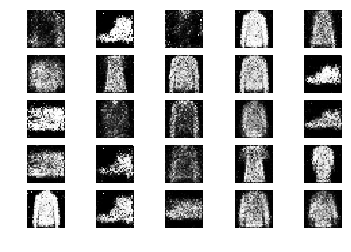

3001 [D loss: 0.566388, acc.: 70.31%] [G loss: 1.069685]
3002 [D loss: 0.670421, acc.: 58.59%] [G loss: 1.063537]
3003 [D loss: 0.612904, acc.: 65.62%] [G loss: 1.106531]
3004 [D loss: 0.620851, acc.: 63.28%] [G loss: 1.045588]
3005 [D loss: 0.601109, acc.: 65.62%] [G loss: 1.182446]
3006 [D loss: 0.609007, acc.: 61.72%] [G loss: 1.078940]
3007 [D loss: 0.589734, acc.: 61.72%] [G loss: 1.017884]
3008 [D loss: 0.618186, acc.: 59.38%] [G loss: 1.048374]
3009 [D loss: 0.655410, acc.: 56.25%] [G loss: 1.168056]
3010 [D loss: 0.602403, acc.: 63.28%] [G loss: 1.146084]
3011 [D loss: 0.541861, acc.: 72.66%] [G loss: 1.151279]
3012 [D loss: 0.568665, acc.: 66.41%] [G loss: 1.086154]
3013 [D loss: 0.672930, acc.: 53.91%] [G loss: 1.109091]
3014 [D loss: 0.487579, acc.: 78.91%] [G loss: 1.171247]
3015 [D loss: 0.615187, acc.: 60.94%] [G loss: 1.184131]
3016 [D loss: 0.559757, acc.: 69.53%] [G loss: 1.197596]
3017 [D loss: 0.577660, acc.: 65.62%] [G loss: 1.261021]
3018 [D loss: 0.539835, acc.: 7

3146 [D loss: 0.576086, acc.: 65.62%] [G loss: 1.280103]
3147 [D loss: 0.608331, acc.: 65.62%] [G loss: 1.112930]
3148 [D loss: 0.598394, acc.: 65.62%] [G loss: 1.145525]
3149 [D loss: 0.548254, acc.: 72.66%] [G loss: 1.112140]
3150 [D loss: 0.598783, acc.: 64.06%] [G loss: 1.066252]
3151 [D loss: 0.530971, acc.: 71.09%] [G loss: 1.057442]
3152 [D loss: 0.595716, acc.: 64.84%] [G loss: 1.151121]
3153 [D loss: 0.547015, acc.: 73.44%] [G loss: 1.141475]
3154 [D loss: 0.595688, acc.: 67.19%] [G loss: 1.047495]
3155 [D loss: 0.571813, acc.: 71.09%] [G loss: 1.111015]
3156 [D loss: 0.557008, acc.: 68.75%] [G loss: 1.158755]
3157 [D loss: 0.559209, acc.: 69.53%] [G loss: 1.136060]
3158 [D loss: 0.579483, acc.: 71.88%] [G loss: 1.096178]
3159 [D loss: 0.546096, acc.: 71.88%] [G loss: 1.098403]
3160 [D loss: 0.548032, acc.: 69.53%] [G loss: 1.091070]
3161 [D loss: 0.572468, acc.: 71.09%] [G loss: 1.047233]
3162 [D loss: 0.566118, acc.: 71.09%] [G loss: 1.183527]
3163 [D loss: 0.614183, acc.: 6

3291 [D loss: 0.542732, acc.: 71.88%] [G loss: 1.172898]
3292 [D loss: 0.472340, acc.: 78.12%] [G loss: 1.226900]
3293 [D loss: 0.628554, acc.: 65.62%] [G loss: 1.133523]
3294 [D loss: 0.577649, acc.: 66.41%] [G loss: 1.074741]
3295 [D loss: 0.542772, acc.: 73.44%] [G loss: 1.121714]
3296 [D loss: 0.591551, acc.: 67.97%] [G loss: 1.189531]
3297 [D loss: 0.547418, acc.: 70.31%] [G loss: 1.176124]
3298 [D loss: 0.598793, acc.: 64.06%] [G loss: 1.165017]
3299 [D loss: 0.547613, acc.: 71.88%] [G loss: 1.031569]
3300 [D loss: 0.559592, acc.: 77.34%] [G loss: 1.136213]
3301 [D loss: 0.586700, acc.: 68.75%] [G loss: 1.148323]
3302 [D loss: 0.587658, acc.: 71.88%] [G loss: 1.122506]
3303 [D loss: 0.580976, acc.: 71.09%] [G loss: 1.093503]
3304 [D loss: 0.568215, acc.: 67.19%] [G loss: 1.055293]
3305 [D loss: 0.594103, acc.: 66.41%] [G loss: 1.076544]
3306 [D loss: 0.593419, acc.: 66.41%] [G loss: 1.135137]
3307 [D loss: 0.597497, acc.: 68.75%] [G loss: 1.130828]
3308 [D loss: 0.581613, acc.: 6

3436 [D loss: 0.614408, acc.: 64.06%] [G loss: 1.139200]
3437 [D loss: 0.567971, acc.: 69.53%] [G loss: 1.140566]
3438 [D loss: 0.570493, acc.: 64.84%] [G loss: 1.071761]
3439 [D loss: 0.711124, acc.: 50.00%] [G loss: 1.135502]
3440 [D loss: 0.549853, acc.: 70.31%] [G loss: 1.131148]
3441 [D loss: 0.611099, acc.: 66.41%] [G loss: 1.133332]
3442 [D loss: 0.618553, acc.: 60.94%] [G loss: 1.067033]
3443 [D loss: 0.658868, acc.: 64.06%] [G loss: 1.012340]
3444 [D loss: 0.550858, acc.: 68.75%] [G loss: 1.069143]
3445 [D loss: 0.553280, acc.: 68.75%] [G loss: 1.093190]
3446 [D loss: 0.651499, acc.: 59.38%] [G loss: 1.153032]
3447 [D loss: 0.567149, acc.: 70.31%] [G loss: 1.120975]
3448 [D loss: 0.602314, acc.: 62.50%] [G loss: 1.059784]
3449 [D loss: 0.549970, acc.: 73.44%] [G loss: 1.124248]
3450 [D loss: 0.602100, acc.: 67.97%] [G loss: 1.122576]
3451 [D loss: 0.624407, acc.: 57.81%] [G loss: 1.056759]
3452 [D loss: 0.686866, acc.: 60.94%] [G loss: 1.115085]
3453 [D loss: 0.602414, acc.: 6

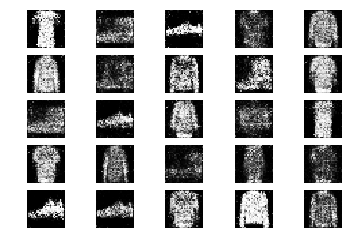

3501 [D loss: 0.593242, acc.: 67.97%] [G loss: 1.094594]
3502 [D loss: 0.543335, acc.: 68.75%] [G loss: 1.182672]
3503 [D loss: 0.593783, acc.: 70.31%] [G loss: 1.042098]
3504 [D loss: 0.631342, acc.: 64.84%] [G loss: 1.081089]
3505 [D loss: 0.563832, acc.: 67.97%] [G loss: 1.117117]
3506 [D loss: 0.567267, acc.: 66.41%] [G loss: 1.195348]
3507 [D loss: 0.622959, acc.: 64.84%] [G loss: 1.208054]
3508 [D loss: 0.610877, acc.: 67.19%] [G loss: 1.210265]
3509 [D loss: 0.553730, acc.: 67.97%] [G loss: 1.131986]
3510 [D loss: 0.595433, acc.: 68.75%] [G loss: 1.111960]
3511 [D loss: 0.578809, acc.: 66.41%] [G loss: 1.112824]
3512 [D loss: 0.586797, acc.: 64.06%] [G loss: 1.074479]
3513 [D loss: 0.585368, acc.: 67.19%] [G loss: 1.171452]
3514 [D loss: 0.679476, acc.: 57.81%] [G loss: 1.079464]
3515 [D loss: 0.609379, acc.: 65.62%] [G loss: 1.103535]
3516 [D loss: 0.578734, acc.: 69.53%] [G loss: 1.132324]
3517 [D loss: 0.554345, acc.: 70.31%] [G loss: 1.186204]
3518 [D loss: 0.640656, acc.: 6

3646 [D loss: 0.570500, acc.: 67.97%] [G loss: 1.146906]
3647 [D loss: 0.548714, acc.: 71.88%] [G loss: 1.086070]
3648 [D loss: 0.698038, acc.: 57.03%] [G loss: 1.087548]
3649 [D loss: 0.621253, acc.: 67.97%] [G loss: 1.105338]
3650 [D loss: 0.630111, acc.: 63.28%] [G loss: 1.085331]
3651 [D loss: 0.644333, acc.: 58.59%] [G loss: 1.104999]
3652 [D loss: 0.593397, acc.: 69.53%] [G loss: 1.099787]
3653 [D loss: 0.572643, acc.: 66.41%] [G loss: 1.071694]
3654 [D loss: 0.567063, acc.: 67.97%] [G loss: 1.198683]
3655 [D loss: 0.576468, acc.: 67.19%] [G loss: 1.120228]
3656 [D loss: 0.590071, acc.: 65.62%] [G loss: 1.059646]
3657 [D loss: 0.628737, acc.: 60.94%] [G loss: 0.995341]
3658 [D loss: 0.590536, acc.: 71.88%] [G loss: 1.055368]
3659 [D loss: 0.604869, acc.: 67.19%] [G loss: 1.018448]
3660 [D loss: 0.618817, acc.: 67.19%] [G loss: 1.082196]
3661 [D loss: 0.549133, acc.: 74.22%] [G loss: 1.107571]
3662 [D loss: 0.562421, acc.: 68.75%] [G loss: 1.116881]
3663 [D loss: 0.652713, acc.: 6

3791 [D loss: 0.641566, acc.: 61.72%] [G loss: 1.069127]
3792 [D loss: 0.612607, acc.: 64.84%] [G loss: 1.089510]
3793 [D loss: 0.619583, acc.: 61.72%] [G loss: 1.088912]
3794 [D loss: 0.665807, acc.: 56.25%] [G loss: 0.974470]
3795 [D loss: 0.573491, acc.: 72.66%] [G loss: 1.077946]
3796 [D loss: 0.588709, acc.: 66.41%] [G loss: 1.061389]
3797 [D loss: 0.620857, acc.: 64.84%] [G loss: 1.026220]
3798 [D loss: 0.613400, acc.: 64.06%] [G loss: 1.106487]
3799 [D loss: 0.571074, acc.: 70.31%] [G loss: 1.091840]
3800 [D loss: 0.632315, acc.: 61.72%] [G loss: 1.133973]
3801 [D loss: 0.618136, acc.: 64.06%] [G loss: 1.074890]
3802 [D loss: 0.662663, acc.: 61.72%] [G loss: 1.100117]
3803 [D loss: 0.600616, acc.: 60.94%] [G loss: 1.122445]
3804 [D loss: 0.575449, acc.: 67.19%] [G loss: 1.120393]
3805 [D loss: 0.608934, acc.: 64.06%] [G loss: 1.024249]
3806 [D loss: 0.601618, acc.: 63.28%] [G loss: 1.031424]
3807 [D loss: 0.603038, acc.: 63.28%] [G loss: 1.041871]
3808 [D loss: 0.642808, acc.: 6

3937 [D loss: 0.572590, acc.: 71.09%] [G loss: 1.085501]
3938 [D loss: 0.565983, acc.: 70.31%] [G loss: 1.016757]
3939 [D loss: 0.701308, acc.: 55.47%] [G loss: 1.020331]
3940 [D loss: 0.626896, acc.: 61.72%] [G loss: 1.016918]
3941 [D loss: 0.592733, acc.: 65.62%] [G loss: 1.016270]
3942 [D loss: 0.606553, acc.: 64.06%] [G loss: 1.009531]
3943 [D loss: 0.623226, acc.: 67.97%] [G loss: 1.066791]
3944 [D loss: 0.599118, acc.: 67.97%] [G loss: 1.147210]
3945 [D loss: 0.641575, acc.: 65.62%] [G loss: 1.083686]
3946 [D loss: 0.602774, acc.: 65.62%] [G loss: 1.095533]
3947 [D loss: 0.636200, acc.: 66.41%] [G loss: 1.050475]
3948 [D loss: 0.628836, acc.: 64.06%] [G loss: 1.107265]
3949 [D loss: 0.663900, acc.: 59.38%] [G loss: 1.054164]
3950 [D loss: 0.621404, acc.: 64.84%] [G loss: 1.058062]
3951 [D loss: 0.606586, acc.: 67.97%] [G loss: 1.041645]
3952 [D loss: 0.617592, acc.: 64.06%] [G loss: 1.032184]
3953 [D loss: 0.678103, acc.: 61.72%] [G loss: 1.004546]
3954 [D loss: 0.608836, acc.: 6

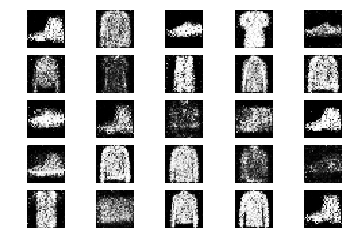

4001 [D loss: 0.597891, acc.: 67.97%] [G loss: 1.037631]
4002 [D loss: 0.595655, acc.: 67.19%] [G loss: 1.010408]
4003 [D loss: 0.617731, acc.: 64.84%] [G loss: 1.034129]
4004 [D loss: 0.578645, acc.: 65.62%] [G loss: 1.021336]
4005 [D loss: 0.646553, acc.: 58.59%] [G loss: 1.076890]
4006 [D loss: 0.596412, acc.: 68.75%] [G loss: 0.994214]
4007 [D loss: 0.578305, acc.: 67.97%] [G loss: 1.003158]
4008 [D loss: 0.556304, acc.: 71.09%] [G loss: 1.015117]
4009 [D loss: 0.583803, acc.: 63.28%] [G loss: 0.938869]
4010 [D loss: 0.596620, acc.: 67.97%] [G loss: 1.047979]
4011 [D loss: 0.637098, acc.: 64.84%] [G loss: 1.047501]
4012 [D loss: 0.594811, acc.: 67.97%] [G loss: 0.998545]
4013 [D loss: 0.680937, acc.: 62.50%] [G loss: 1.049519]
4014 [D loss: 0.546770, acc.: 70.31%] [G loss: 1.088217]
4015 [D loss: 0.591354, acc.: 67.97%] [G loss: 1.064188]
4016 [D loss: 0.600519, acc.: 58.59%] [G loss: 1.116688]
4017 [D loss: 0.580301, acc.: 67.19%] [G loss: 1.045239]
4018 [D loss: 0.618122, acc.: 6

4145 [D loss: 0.636065, acc.: 56.25%] [G loss: 1.060898]
4146 [D loss: 0.648185, acc.: 64.84%] [G loss: 1.021900]
4147 [D loss: 0.687994, acc.: 57.03%] [G loss: 1.034896]
4148 [D loss: 0.573780, acc.: 66.41%] [G loss: 1.213677]
4149 [D loss: 0.604433, acc.: 64.84%] [G loss: 1.113315]
4150 [D loss: 0.670627, acc.: 61.72%] [G loss: 1.039376]
4151 [D loss: 0.619987, acc.: 66.41%] [G loss: 1.050791]
4152 [D loss: 0.640420, acc.: 68.75%] [G loss: 1.014669]
4153 [D loss: 0.692968, acc.: 59.38%] [G loss: 0.951619]
4154 [D loss: 0.572563, acc.: 70.31%] [G loss: 1.053742]
4155 [D loss: 0.652973, acc.: 58.59%] [G loss: 1.053768]
4156 [D loss: 0.561649, acc.: 71.88%] [G loss: 1.079701]
4157 [D loss: 0.554371, acc.: 73.44%] [G loss: 1.050064]
4158 [D loss: 0.573438, acc.: 71.88%] [G loss: 1.157146]
4159 [D loss: 0.582020, acc.: 69.53%] [G loss: 1.036360]
4160 [D loss: 0.585413, acc.: 67.19%] [G loss: 1.022990]
4161 [D loss: 0.534905, acc.: 75.78%] [G loss: 1.107347]
4162 [D loss: 0.609232, acc.: 6

4291 [D loss: 0.663981, acc.: 58.59%] [G loss: 1.027134]
4292 [D loss: 0.547580, acc.: 68.75%] [G loss: 0.950386]
4293 [D loss: 0.600255, acc.: 64.84%] [G loss: 0.964437]
4294 [D loss: 0.578769, acc.: 67.97%] [G loss: 0.983356]
4295 [D loss: 0.651142, acc.: 60.16%] [G loss: 1.011111]
4296 [D loss: 0.557801, acc.: 65.62%] [G loss: 1.020994]
4297 [D loss: 0.680418, acc.: 57.81%] [G loss: 1.026514]
4298 [D loss: 0.604053, acc.: 60.16%] [G loss: 0.951039]
4299 [D loss: 0.636845, acc.: 58.59%] [G loss: 0.966615]
4300 [D loss: 0.594251, acc.: 66.41%] [G loss: 0.980526]
4301 [D loss: 0.594196, acc.: 68.75%] [G loss: 0.931307]
4302 [D loss: 0.555857, acc.: 74.22%] [G loss: 0.904137]
4303 [D loss: 0.586743, acc.: 66.41%] [G loss: 0.974681]
4304 [D loss: 0.663699, acc.: 58.59%] [G loss: 0.961857]
4305 [D loss: 0.541348, acc.: 75.00%] [G loss: 1.046489]
4306 [D loss: 0.602450, acc.: 65.62%] [G loss: 1.001873]
4307 [D loss: 0.647990, acc.: 59.38%] [G loss: 0.997418]
4308 [D loss: 0.598113, acc.: 6

4436 [D loss: 0.652400, acc.: 56.25%] [G loss: 0.950424]
4437 [D loss: 0.627067, acc.: 60.94%] [G loss: 0.933747]
4438 [D loss: 0.616892, acc.: 60.94%] [G loss: 0.954370]
4439 [D loss: 0.657009, acc.: 58.59%] [G loss: 0.956030]
4440 [D loss: 0.611817, acc.: 63.28%] [G loss: 0.972137]
4441 [D loss: 0.611593, acc.: 61.72%] [G loss: 0.985703]
4442 [D loss: 0.599599, acc.: 69.53%] [G loss: 1.007752]
4443 [D loss: 0.672016, acc.: 58.59%] [G loss: 1.010107]
4444 [D loss: 0.597225, acc.: 64.06%] [G loss: 1.039052]
4445 [D loss: 0.663099, acc.: 61.72%] [G loss: 0.971316]
4446 [D loss: 0.639251, acc.: 59.38%] [G loss: 0.958764]
4447 [D loss: 0.595352, acc.: 66.41%] [G loss: 1.078315]
4448 [D loss: 0.585188, acc.: 68.75%] [G loss: 0.982510]
4449 [D loss: 0.606754, acc.: 65.62%] [G loss: 1.012777]
4450 [D loss: 0.609375, acc.: 61.72%] [G loss: 0.995002]
4451 [D loss: 0.608083, acc.: 64.06%] [G loss: 1.042881]
4452 [D loss: 0.627297, acc.: 62.50%] [G loss: 0.976716]
4453 [D loss: 0.615763, acc.: 6

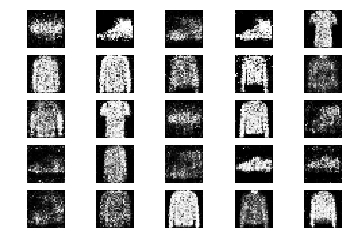

4501 [D loss: 0.653960, acc.: 61.72%] [G loss: 1.020777]
4502 [D loss: 0.600783, acc.: 64.84%] [G loss: 0.968896]
4503 [D loss: 0.638291, acc.: 64.84%] [G loss: 1.025199]
4504 [D loss: 0.619123, acc.: 64.84%] [G loss: 1.061716]
4505 [D loss: 0.663096, acc.: 60.16%] [G loss: 0.935149]
4506 [D loss: 0.606769, acc.: 63.28%] [G loss: 0.996915]
4507 [D loss: 0.628084, acc.: 63.28%] [G loss: 0.930425]
4508 [D loss: 0.640113, acc.: 59.38%] [G loss: 1.003629]
4509 [D loss: 0.597985, acc.: 63.28%] [G loss: 1.041143]
4510 [D loss: 0.599647, acc.: 66.41%] [G loss: 1.010939]
4511 [D loss: 0.636203, acc.: 57.81%] [G loss: 1.081118]
4512 [D loss: 0.563192, acc.: 69.53%] [G loss: 1.049004]
4513 [D loss: 0.660892, acc.: 61.72%] [G loss: 1.014368]
4514 [D loss: 0.634027, acc.: 60.16%] [G loss: 1.015848]
4515 [D loss: 0.655156, acc.: 56.25%] [G loss: 1.037931]
4516 [D loss: 0.690176, acc.: 56.25%] [G loss: 0.944655]
4517 [D loss: 0.580630, acc.: 71.88%] [G loss: 0.943600]
4518 [D loss: 0.641497, acc.: 6

4645 [D loss: 0.606360, acc.: 67.97%] [G loss: 1.030462]
4646 [D loss: 0.663402, acc.: 63.28%] [G loss: 1.025165]
4647 [D loss: 0.640283, acc.: 64.06%] [G loss: 0.967519]
4648 [D loss: 0.606967, acc.: 64.06%] [G loss: 1.009644]
4649 [D loss: 0.683034, acc.: 64.84%] [G loss: 1.045435]
4650 [D loss: 0.651606, acc.: 58.59%] [G loss: 1.001400]
4651 [D loss: 0.603739, acc.: 64.06%] [G loss: 1.052870]
4652 [D loss: 0.619443, acc.: 66.41%] [G loss: 1.015574]
4653 [D loss: 0.620828, acc.: 67.97%] [G loss: 0.961118]
4654 [D loss: 0.645051, acc.: 61.72%] [G loss: 0.934407]
4655 [D loss: 0.637075, acc.: 64.06%] [G loss: 0.948671]
4656 [D loss: 0.685596, acc.: 53.12%] [G loss: 0.955725]
4657 [D loss: 0.636054, acc.: 68.75%] [G loss: 0.899298]
4658 [D loss: 0.659232, acc.: 58.59%] [G loss: 0.915048]
4659 [D loss: 0.647218, acc.: 60.94%] [G loss: 1.043249]
4660 [D loss: 0.667016, acc.: 57.03%] [G loss: 0.938991]
4661 [D loss: 0.582240, acc.: 71.09%] [G loss: 1.026666]
4662 [D loss: 0.691734, acc.: 5

4789 [D loss: 0.626624, acc.: 61.72%] [G loss: 1.080692]
4790 [D loss: 0.625366, acc.: 62.50%] [G loss: 1.103923]
4791 [D loss: 0.602183, acc.: 64.84%] [G loss: 1.097385]
4792 [D loss: 0.655865, acc.: 59.38%] [G loss: 0.965053]
4793 [D loss: 0.636980, acc.: 61.72%] [G loss: 0.975025]
4794 [D loss: 0.600339, acc.: 64.06%] [G loss: 1.065718]
4795 [D loss: 0.643057, acc.: 61.72%] [G loss: 1.068412]
4796 [D loss: 0.611959, acc.: 63.28%] [G loss: 1.082821]
4797 [D loss: 0.616857, acc.: 63.28%] [G loss: 1.013481]
4798 [D loss: 0.654175, acc.: 61.72%] [G loss: 0.918509]
4799 [D loss: 0.648990, acc.: 64.06%] [G loss: 0.905064]
4800 [D loss: 0.643973, acc.: 60.16%] [G loss: 1.017569]
4801 [D loss: 0.638465, acc.: 64.06%] [G loss: 1.003044]
4802 [D loss: 0.634116, acc.: 63.28%] [G loss: 1.037409]
4803 [D loss: 0.601617, acc.: 63.28%] [G loss: 0.956990]
4804 [D loss: 0.648692, acc.: 58.59%] [G loss: 0.973895]
4805 [D loss: 0.624308, acc.: 63.28%] [G loss: 1.010064]
4806 [D loss: 0.652887, acc.: 5

4933 [D loss: 0.610751, acc.: 60.94%] [G loss: 0.937196]
4934 [D loss: 0.643118, acc.: 60.94%] [G loss: 0.990777]
4935 [D loss: 0.646626, acc.: 58.59%] [G loss: 1.021779]
4936 [D loss: 0.639799, acc.: 64.06%] [G loss: 1.051038]
4937 [D loss: 0.623843, acc.: 66.41%] [G loss: 1.016055]
4938 [D loss: 0.650414, acc.: 59.38%] [G loss: 1.001784]
4939 [D loss: 0.601562, acc.: 64.06%] [G loss: 1.033888]
4940 [D loss: 0.618767, acc.: 60.94%] [G loss: 1.014302]
4941 [D loss: 0.615617, acc.: 63.28%] [G loss: 0.962714]
4942 [D loss: 0.647832, acc.: 63.28%] [G loss: 1.042495]
4943 [D loss: 0.615665, acc.: 64.84%] [G loss: 0.991913]
4944 [D loss: 0.613558, acc.: 64.84%] [G loss: 1.037758]
4945 [D loss: 0.642455, acc.: 65.62%] [G loss: 0.965784]
4946 [D loss: 0.579463, acc.: 71.88%] [G loss: 0.883386]
4947 [D loss: 0.663938, acc.: 55.47%] [G loss: 0.919501]
4948 [D loss: 0.636491, acc.: 64.84%] [G loss: 1.017942]
4949 [D loss: 0.645576, acc.: 61.72%] [G loss: 1.054745]
4950 [D loss: 0.612106, acc.: 6

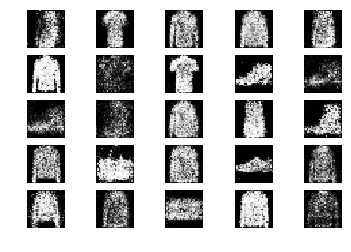

5001 [D loss: 0.577341, acc.: 67.19%] [G loss: 1.003189]
5002 [D loss: 0.653215, acc.: 59.38%] [G loss: 0.978025]
5003 [D loss: 0.618943, acc.: 66.41%] [G loss: 1.011070]
5004 [D loss: 0.614378, acc.: 59.38%] [G loss: 0.929684]
5005 [D loss: 0.563641, acc.: 67.19%] [G loss: 0.943165]
5006 [D loss: 0.608773, acc.: 70.31%] [G loss: 1.020186]
5007 [D loss: 0.677330, acc.: 55.47%] [G loss: 1.091204]
5008 [D loss: 0.627470, acc.: 62.50%] [G loss: 0.955240]
5009 [D loss: 0.614752, acc.: 64.84%] [G loss: 0.974528]
5010 [D loss: 0.612396, acc.: 67.19%] [G loss: 1.042211]
5011 [D loss: 0.549186, acc.: 68.75%] [G loss: 0.969355]
5012 [D loss: 0.651830, acc.: 64.84%] [G loss: 0.949467]
5013 [D loss: 0.639520, acc.: 60.16%] [G loss: 1.006389]
5014 [D loss: 0.576320, acc.: 67.19%] [G loss: 1.084962]
5015 [D loss: 0.646762, acc.: 62.50%] [G loss: 0.973642]
5016 [D loss: 0.649031, acc.: 63.28%] [G loss: 1.074986]
5017 [D loss: 0.619908, acc.: 64.84%] [G loss: 1.070423]
5018 [D loss: 0.660204, acc.: 5

5145 [D loss: 0.707591, acc.: 57.03%] [G loss: 0.985005]
5146 [D loss: 0.607686, acc.: 63.28%] [G loss: 1.051800]
5147 [D loss: 0.638526, acc.: 60.94%] [G loss: 0.965251]
5148 [D loss: 0.639159, acc.: 57.81%] [G loss: 0.951705]
5149 [D loss: 0.644141, acc.: 58.59%] [G loss: 0.945158]
5150 [D loss: 0.630242, acc.: 55.47%] [G loss: 0.968002]
5151 [D loss: 0.627698, acc.: 59.38%] [G loss: 0.951577]
5152 [D loss: 0.635009, acc.: 66.41%] [G loss: 1.008043]
5153 [D loss: 0.647181, acc.: 56.25%] [G loss: 0.955091]
5154 [D loss: 0.601725, acc.: 67.19%] [G loss: 0.981416]
5155 [D loss: 0.693029, acc.: 53.91%] [G loss: 0.996908]
5156 [D loss: 0.624320, acc.: 64.84%] [G loss: 0.979612]
5157 [D loss: 0.625500, acc.: 65.62%] [G loss: 1.012836]
5158 [D loss: 0.637880, acc.: 65.62%] [G loss: 0.982091]
5159 [D loss: 0.590521, acc.: 65.62%] [G loss: 1.023412]
5160 [D loss: 0.650939, acc.: 59.38%] [G loss: 0.973429]
5161 [D loss: 0.563821, acc.: 67.97%] [G loss: 1.010643]
5162 [D loss: 0.681581, acc.: 5

5290 [D loss: 0.663300, acc.: 60.94%] [G loss: 0.980664]
5291 [D loss: 0.635238, acc.: 57.81%] [G loss: 0.985478]
5292 [D loss: 0.647313, acc.: 62.50%] [G loss: 1.035111]
5293 [D loss: 0.589184, acc.: 65.62%] [G loss: 0.988481]
5294 [D loss: 0.663238, acc.: 56.25%] [G loss: 0.923396]
5295 [D loss: 0.624599, acc.: 56.25%] [G loss: 0.959759]
5296 [D loss: 0.615507, acc.: 55.47%] [G loss: 1.020038]
5297 [D loss: 0.614634, acc.: 63.28%] [G loss: 0.995552]
5298 [D loss: 0.614995, acc.: 65.62%] [G loss: 1.001332]
5299 [D loss: 0.644796, acc.: 60.94%] [G loss: 0.990787]
5300 [D loss: 0.659150, acc.: 59.38%] [G loss: 0.946270]
5301 [D loss: 0.615488, acc.: 66.41%] [G loss: 0.968985]
5302 [D loss: 0.695255, acc.: 53.12%] [G loss: 0.968454]
5303 [D loss: 0.585083, acc.: 69.53%] [G loss: 1.023752]
5304 [D loss: 0.634980, acc.: 60.94%] [G loss: 0.886236]
5305 [D loss: 0.657544, acc.: 57.81%] [G loss: 0.966565]
5306 [D loss: 0.564324, acc.: 67.97%] [G loss: 1.018033]
5307 [D loss: 0.589522, acc.: 6

5435 [D loss: 0.676913, acc.: 55.47%] [G loss: 1.014554]
5436 [D loss: 0.637090, acc.: 67.19%] [G loss: 0.946738]
5437 [D loss: 0.614662, acc.: 64.06%] [G loss: 0.996289]
5438 [D loss: 0.665227, acc.: 54.69%] [G loss: 0.984591]
5439 [D loss: 0.631904, acc.: 63.28%] [G loss: 0.917144]
5440 [D loss: 0.635774, acc.: 64.06%] [G loss: 0.943896]
5441 [D loss: 0.615553, acc.: 59.38%] [G loss: 0.965076]
5442 [D loss: 0.612830, acc.: 67.19%] [G loss: 0.882272]
5443 [D loss: 0.603477, acc.: 66.41%] [G loss: 0.954285]
5444 [D loss: 0.676319, acc.: 64.06%] [G loss: 0.856270]
5445 [D loss: 0.674185, acc.: 57.81%] [G loss: 0.939553]
5446 [D loss: 0.664767, acc.: 63.28%] [G loss: 0.893950]
5447 [D loss: 0.616226, acc.: 60.94%] [G loss: 1.044687]
5448 [D loss: 0.728367, acc.: 50.00%] [G loss: 1.011080]
5449 [D loss: 0.662458, acc.: 56.25%] [G loss: 0.990793]
5450 [D loss: 0.694000, acc.: 57.03%] [G loss: 0.952678]
5451 [D loss: 0.663792, acc.: 59.38%] [G loss: 0.911660]
5452 [D loss: 0.617006, acc.: 6

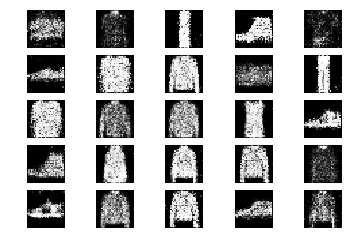

5501 [D loss: 0.654008, acc.: 60.16%] [G loss: 0.921830]
5502 [D loss: 0.660003, acc.: 61.72%] [G loss: 0.942008]
5503 [D loss: 0.606687, acc.: 67.19%] [G loss: 0.900156]
5504 [D loss: 0.654516, acc.: 59.38%] [G loss: 0.896657]
5505 [D loss: 0.665190, acc.: 58.59%] [G loss: 0.934478]
5506 [D loss: 0.635639, acc.: 61.72%] [G loss: 0.885149]
5507 [D loss: 0.607533, acc.: 64.06%] [G loss: 0.972425]
5508 [D loss: 0.647249, acc.: 54.69%] [G loss: 0.949787]
5509 [D loss: 0.655625, acc.: 60.16%] [G loss: 0.929362]
5510 [D loss: 0.625801, acc.: 57.81%] [G loss: 0.948237]
5511 [D loss: 0.624403, acc.: 61.72%] [G loss: 0.945817]
5512 [D loss: 0.587391, acc.: 64.84%] [G loss: 0.952515]
5513 [D loss: 0.628217, acc.: 57.81%] [G loss: 0.939856]
5514 [D loss: 0.666116, acc.: 54.69%] [G loss: 0.919339]
5515 [D loss: 0.658531, acc.: 60.94%] [G loss: 0.934720]
5516 [D loss: 0.662443, acc.: 59.38%] [G loss: 0.921541]
5517 [D loss: 0.630777, acc.: 60.16%] [G loss: 0.955608]
5518 [D loss: 0.649817, acc.: 5

5647 [D loss: 0.596002, acc.: 64.84%] [G loss: 0.913744]
5648 [D loss: 0.659726, acc.: 57.03%] [G loss: 0.942600]
5649 [D loss: 0.655831, acc.: 61.72%] [G loss: 0.990746]
5650 [D loss: 0.645689, acc.: 57.81%] [G loss: 0.971876]
5651 [D loss: 0.642286, acc.: 59.38%] [G loss: 0.908578]
5652 [D loss: 0.648584, acc.: 60.16%] [G loss: 0.885672]
5653 [D loss: 0.650608, acc.: 60.16%] [G loss: 0.848258]
5654 [D loss: 0.646430, acc.: 60.16%] [G loss: 0.913841]
5655 [D loss: 0.668541, acc.: 58.59%] [G loss: 0.942279]
5656 [D loss: 0.634273, acc.: 60.94%] [G loss: 0.954015]
5657 [D loss: 0.614265, acc.: 64.84%] [G loss: 0.908780]
5658 [D loss: 0.626766, acc.: 67.19%] [G loss: 0.916437]
5659 [D loss: 0.625255, acc.: 60.16%] [G loss: 0.864207]
5660 [D loss: 0.673495, acc.: 59.38%] [G loss: 0.938555]
5661 [D loss: 0.619120, acc.: 64.84%] [G loss: 0.958271]
5662 [D loss: 0.688414, acc.: 50.78%] [G loss: 0.877810]
5663 [D loss: 0.621238, acc.: 67.19%] [G loss: 0.925401]
5664 [D loss: 0.654032, acc.: 6

5792 [D loss: 0.586442, acc.: 65.62%] [G loss: 0.972287]
5793 [D loss: 0.607148, acc.: 60.94%] [G loss: 0.930065]
5794 [D loss: 0.654162, acc.: 58.59%] [G loss: 0.850200]
5795 [D loss: 0.655436, acc.: 60.16%] [G loss: 0.883771]
5796 [D loss: 0.628886, acc.: 59.38%] [G loss: 0.990675]
5797 [D loss: 0.619998, acc.: 60.16%] [G loss: 1.049289]
5798 [D loss: 0.622355, acc.: 63.28%] [G loss: 1.034579]
5799 [D loss: 0.650354, acc.: 59.38%] [G loss: 0.958830]
5800 [D loss: 0.588468, acc.: 68.75%] [G loss: 0.861383]
5801 [D loss: 0.602853, acc.: 67.19%] [G loss: 0.954139]
5802 [D loss: 0.615559, acc.: 64.06%] [G loss: 0.911288]
5803 [D loss: 0.656229, acc.: 56.25%] [G loss: 0.915674]
5804 [D loss: 0.617742, acc.: 59.38%] [G loss: 0.976529]
5805 [D loss: 0.665451, acc.: 60.94%] [G loss: 0.950951]
5806 [D loss: 0.654283, acc.: 56.25%] [G loss: 0.986020]
5807 [D loss: 0.630963, acc.: 63.28%] [G loss: 0.967590]
5808 [D loss: 0.597899, acc.: 64.84%] [G loss: 0.949126]
5809 [D loss: 0.594061, acc.: 6

5938 [D loss: 0.654814, acc.: 57.81%] [G loss: 0.972311]
5939 [D loss: 0.599010, acc.: 65.62%] [G loss: 0.922295]
5940 [D loss: 0.651909, acc.: 62.50%] [G loss: 0.924372]
5941 [D loss: 0.642535, acc.: 64.84%] [G loss: 0.851611]
5942 [D loss: 0.702236, acc.: 52.34%] [G loss: 1.023772]
5943 [D loss: 0.610938, acc.: 63.28%] [G loss: 0.975687]
5944 [D loss: 0.620673, acc.: 67.19%] [G loss: 1.056705]
5945 [D loss: 0.631895, acc.: 63.28%] [G loss: 0.989790]
5946 [D loss: 0.659534, acc.: 57.03%] [G loss: 0.970781]
5947 [D loss: 0.661000, acc.: 56.25%] [G loss: 0.987032]
5948 [D loss: 0.597632, acc.: 64.84%] [G loss: 0.981450]
5949 [D loss: 0.674703, acc.: 55.47%] [G loss: 0.968764]
5950 [D loss: 0.612520, acc.: 64.84%] [G loss: 0.909818]
5951 [D loss: 0.622301, acc.: 58.59%] [G loss: 0.943769]
5952 [D loss: 0.710207, acc.: 50.78%] [G loss: 0.942264]
5953 [D loss: 0.682838, acc.: 49.22%] [G loss: 0.861314]
5954 [D loss: 0.643237, acc.: 59.38%] [G loss: 0.902590]
5955 [D loss: 0.672916, acc.: 5

In [48]:
if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=6000, batch_size=64, sample_interval=500)

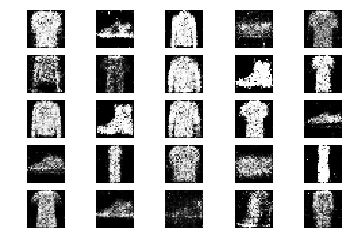

In [49]:
gan.sample_images(30)

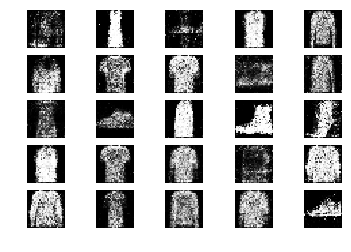

In [50]:
gan.sample_images(900)

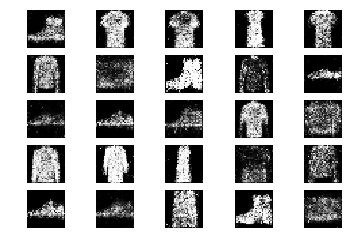

In [51]:
gan.sample_images(2999)

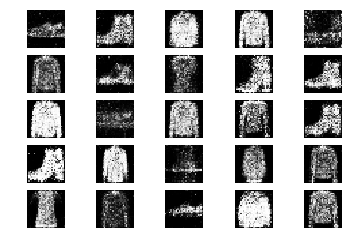

In [53]:
gan.sample_images(5999)